<a href="https://colab.research.google.com/github/treetops81/Twitter-COP26/blob/main/Twitter_API_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explatory analysis - COP26 Tweets during event
I applied for a twitter API license and pulled tweets during the COP26 event that related to COP26 and climate change, to investigate the public's sentiment around the event and what they were most interested in.

### What would I like to find out:


1.   What are the key themes that people are talking about?
2.   What is the overall public sentiment of the event? Can I compare this to twitter / social media benchmark?
3. Does sentiment vary over the different themes of discussion?
4. Can we see any significant climate denial coming through?
5. Named Entity Recognition - can we extract any usefu NER insights?

In [2]:
%%capture
# Download required packages that are not available already on google colab.
!pip install demoji
!pip install spacytextblob
!python -m spacy download en_core_web_lg 
!pip install git+https://github.com/rwalk/gsdmm.git
!pip install vaderSentiment

Model v1 contains climate change
Model v2 removes climate change by making it a stop word

## Import required libraries
If required, run the above code upon opening so that google colab has the required libraries 

In [3]:
# Import required libraries

# Twitter specific
import tweepy

# General analysis packages
import pandas as pd
import numpy as np
import json
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pickle
import nltk
from nltk.cluster.kmeans import KMeansClusterer
import random

# Language Packages
import demoji  
from string import punctuation
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from textblob import TextBlob
from gsdmm import MovieGroupProcess
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Preload the spacy model
nlp = spacy.load("en_core_web_lg")
nlp.add_pipe('spacytextblob') # Allows us to use the textblob sentiment analysis tools with spacy
# Add any other required stop words
nlp.Defaults.stop_words.add("cop26")

# Redirect the current python folder to where the Twitter files are located
os.chdir(r'/content/drive/MyDrive/Colab Notebooks/Twitter/') # If you map this to where this notebook is saved then gsdmm shoud install in the same location

## 0. Load and clean data

In [4]:
# # Make sure that Google Drive is mounted before trying to call the below
# # Loads my private twitter keys
# %run "Twitter Info.ipynb"

In [5]:
# # Set up twitter API authentication 
# auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_secret)
# api = tweepy.API(auth)

In [6]:
# Load the combined and partially cleaned dataset
tweet_df = pd.read_csv('tweet_df_initial_clean.csv', encoding = 'utf-8', index_col = 0)

# My pull out emojis from the tweet data (descriptions)
tweet_df['emojis'] = tweet_df['tweets'].apply(lambda x: list(demoji.findall(x).values()))

# Flag tweets containing links - these usually refer to another tweet or picture that doesn't provide us any information.
def find_link(text):
    if 'https' in text:
        return True
    else: 
        return False

tweet_df['link_check'] = tweet_df['tweets'].apply(lambda x: find_link(x))

In [7]:
# Finds mentions in tweets and creates a new column. 
# Regex expression checks that no @ or letters (or numbers) proceed an @ symbol and then capture to 25 a-Z 0-9 characters afterwards.
tweet_df['mentions'] = tweet_df.tweets.str.findall(r'(?<![@\w])@(\w{1,25})')

In [8]:
# Replace emojis with their description in words in a string using demoji function replace_with_desc
def replace_emoji(text):
    text = replace_with_desc(text, "")
    return text

In [9]:
# Remove Emojis from text strings - Useful website for finding unicodes of emojis not currently included: https://unicode.org/emoji/charts/full-emoji-list.html#231b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002318-\U0001F566"  # clocks
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [10]:
# Remove links from text
def remove_links(text):
    url_pattern = re.compile(r"http\S+")
    return re.sub(url_pattern, '', text)

In [11]:
# Remove dates (run before remove punctuation) - Very Basic Version
def remove_dates(text):
    text = re.sub('\d+(\/\d+)+', '', text) # Removes digits seperated by forward slashes 
    return text

In [12]:
# Omit full stops and @ symbols from the punctuation variable (may be useful for other types of analysis)
punctuation_edit = punctuation[:13] + punctuation[14:21] + punctuation[22:]
punctuation_edit

'!"#$%&\'()*+,-/:;<=>?[\\]^_`{|}~'

In [13]:
# Remove all punctuation except for omissions in punctution_edit / punctutation
def remove_punc(text):
    text = ' '.join(text.split())
    text = re.sub('/', ' ', text)
    text = (text.encode('ascii', 'ignore')).decode()
    text = re.sub(' +', ' ', text)
    text = re.sub(r' +\. +', '. ', text)
    text = text.strip()
    text = ''.join([char for char in text if char not in punctuation])
    #text = ''.join([char for char in text if char not in punctuation_edit]) # Omits '.' & '@'
    return text

In [14]:
# Remove mentions from text
def remove_mention(text):
    return re.sub('@\w+', '', text)

In [15]:
# Clean text, calling all the sub-cleaning functions
def clean_text(text):
    #text = text.lower() - Preprocessing late via SpaCy does the same thing and this makes text more readible until then.
    #text = replace_emoji(text)
    text = re.sub('&amp;', 'and', text) # Replace &amp: with '&' - encoding error
    text = remove_emoji(text)
    text = remove_links(text)
    text = remove_dates(text)
    text = remove_mention(text)
    text = remove_punc(text) 
    return text

In [16]:
# Create a new column based of the cleaning function
tweet_df['clean_tweet'] = tweet_df['tweets'].apply(lambda x: clean_text(x))
tweet_df.head(3)

,tweets,likes,time,verified,user,hashtags,emojis,link_check,mentions,clean_tweet
0,#COP26 has been named the must excluding COP e...,53660,2021-11-04 16:20:40,True,Greta Thunberg,"[{'text': 'COP26', 'indices': [0, 6]}]",[],False,[],COP26 has been named the must excluding COP ev...
1,Indonesia reversed a #COP26 pledge to end defo...,5618,2021-11-04 14:31:00,True,AJ+,"[{'text': 'COP26', 'indices': [21, 27]}]",[],True,[],Indonesia reversed a COP26 pledge to end defor...
2,Sir David Attenborough full speech to World Le...,5227,2021-11-04 10:10:55,True,Chris Packham,"[{'text': 'COP26', 'indices': [69, 75]}, {'tex...",[],True,[],Sir David Attenborough full speech to World Le...


In [17]:
# Remove 'to_remove items' from a target list - used to clean the hashtags column read directly from Twitter API
# Input: list (target) & str/list containing items to remove, Output: list (target minus the defined items)
def remove_all(target_list, to_remove):
    if isinstance(to_remove, str): # Remove from a string
        for item in target_list:
            if item == to_remove:
                target_list.remove(to_remove) 
    
    elif isinstance(to_remove, list): # Remove from a list
        for rem_item in to_remove:
            for item in target_list:
                if item == rem_item:
                    target_list.remove(rem_item) 

    return target_list

In [18]:
# Take in the hashtags format from twitter, extract the hashtags by finding the text within the entry and remove the words 'text' and 'indices'
def fix_hashtags(hashtag_list):
    hashtag_string = re.findall(r"'(.*?)'", hashtag_list)
    hashtag_list_out = remove_all(hashtag_string, ['text', 'indices'])
    return hashtag_list_out

In [19]:
# Apply fix_hashtags
tweet_df['hashtags_clean'] = tweet_df['hashtags'].apply(lambda x: fix_hashtags(x))

# Drop old hashtag column and reorder columns
tweet_df.drop(columns = ['hashtags'])
tweet_df = tweet_df.reindex(columns = ['clean_tweet', 'emojis', 'hashtags_clean', 'mentions', 'likes', 'link_check', 'time', 'verified', 'user', 'tweets'])
tweet_df.to_csv('tweet_df.csv', encoding = 'utf-8')

## 0.5 Quick analysis of hashtags, emojis and mentions within our dataset

In [20]:
# Look at the number of duplicate tweets
print(tweet_df.shape[0])
print(tweet_df.clean_tweet.value_counts()[tweet_df.clean_tweet.value_counts() > 1].sum())

40708
4031


In [21]:
# Drop duplicates, sorting by tweet and then likes
def drop_dupes(df):
    sorted_df = df.sort_values(by=['clean_tweet', 'likes'])
    df_trimmed = df.drop_duplicates(subset=['clean_tweet'])
    df_trimmed = df_trimmed.sort_index()
    return df_trimmed.reset_index(drop=True)

In [22]:
# Print df shape
print(tweet_df.shape)

# Drop duplicates and reprint shape
tweet_df = drop_dupes(tweet_df)
print(tweet_df.shape)

(40708, 10)
(37822, 10)


In [23]:
# Look at user counts and tweets per user to check that no one user is a major component of our dataset
print('Total number of users in dataset:', len(tweet_df.user.unique()))
tweet_df.user.value_counts()

Total number of users in dataset: 27616


RSMacKinnon (he/him)    54
UNFCCC                  50
Top Banana Antiques     47
Greta Thunberg News     34
Sky News                29
                        ..
Jesus Garcia             1
Finance World💰           1
Al Chisholm              1
Cornelia Rumpel          1
Xynteo                   1
Name: user, Length: 27616, dtype: int64

In [24]:
# Create some variables describing the hashtags found in our tweets
# None of these look out of place
hashtag_list = tweet_df.hashtags_clean.to_list()
all_hashtags = [hash.lower() for hashtag in hashtag_list for hash in hashtag] # List of all hashtags (with repetition)
unique_hashes = list(set(all_hashtags)) # List of all hashtags (without repitition)
hash_counts = dict(zip(unique_hashes, [all_hashtags.count(hash) for hash in unique_hashes])) # Dictionary of hashtag counts
hash_counter = Counter(hash_counts)
common_hashes = hash_counter.most_common(20)
for i in common_hashes:
    print(i[0], ':', i[1])

cop26 : 17983
climatechange : 1749
climateaction : 1221
climatecrisis : 900
climate : 872
cop26glasgow : 758
climateemergency : 647
togetherforourplanet : 636
netzero : 463
climatejustice : 392
glasgow : 370
sustainability : 320
climateactionnow : 288
environment : 240
uprootthesystem : 236
auspol : 220
globalwarming : 215
klimalaya : 202
worldclimatemarch : 185
endclimateimperialism : 175


In [25]:
# Create some variables describing the mentions found in our tweets
# None of these look out of place - note that Veritatem2021 is an anti climate change account
mention_list = tweet_df.mentions.to_list()
all_mention = [mention.lower() for mention_sub_list in mention_list for mention in mention_sub_list] # List of all mentions (with repetition)
unique_mention = list(set(all_mention)) # List of all mentions (without repitition)
mention_counts = dict(zip(unique_mention, [all_mention.count(mention) for mention in unique_mention])) # Dictionary of mention counts
mention_counter = Counter(mention_counts)
common_mention = mention_counter.most_common(20)
for i in common_mention:
    print(i[0], ':', i[1])

cop26 : 3583
borisjohnson : 1097
gretathunberg : 278
unfccc : 268
aloksharma_rdg : 264
youtube : 186
un : 167
nicolasturgeon : 163
cop26_coalition : 153
potus : 152
unep : 123
skynews : 122
breezyscroll : 109
bbcnews : 102
scottmorrisonmp : 99
geraldkutney : 98
ejwwest : 93
veritatem2021 : 87
gbnews : 86
georgemonbiot : 85


In [26]:
# Create some variables describing the emojis found in our tweets
# A lot of the emojis seem to be a reference the tweet (i.e index finger pointing right or left) so we may be want to remove them and only add in sentiment where its positive or negative, i.e. smiley faces
emoji_list = tweet_df.emojis.to_list()
all_emojis = [emojis.lower() for emoji_sub_list in emoji_list for emojis in emoji_sub_list] # List of all emojis (with repetition)
unique_emoji = list(set(all_emojis)) # List of all emojis (without repitition)
emoji_counts = dict(zip(unique_emoji, [all_emojis.count(emojis) for emojis in unique_emoji])) # Dictionary of emojid counts
emoji_counter = Counter(emoji_counts)
common_emojis = emoji_counter.most_common(20)
for i in common_emojis:
    print(i[0], ':', i[1])

globe showing europe-africa : 541
backhand index pointing down : 501
backhand index pointing right : 378
globe showing americas : 297
right arrow : 245
green heart : 205
down arrow : 164
thinking face : 152
globe showing asia-australia : 150
face with tears of joy : 149
seedling : 143
deciduous tree : 138
rolling on the floor laughing : 124
clapping hands : 122
loudspeaker : 117
face with rolling eyes : 99
flag: united kingdom : 97
flag: scotland : 89
thumbs up : 88
fire : 85


## 1. Topic Modelling - Preprocessing via Spacy

Spacy is a well known industry standard package for dealing with text, having several inbuilt functionalities.
* Full documentation available here: https://spacy.io/usage/spacy-101

In [27]:
# Apply spacy preprocessing to the documents in our dataset
docs = list(nlp.pipe(tweet_df.clean_tweet))

tweet_df['spacy'] = docs

In [28]:
# Taking a spacy pipeline document, return bool True / False if there is a noun in document
def find_noun(spacy_doc):
    noun_flag = 0
    for token in spacy_doc:
        if token.pos_ in ('PROPN', 'PRON', 'NOUN'):
            noun_flag = 1
            break

    if noun_flag == 1:
        return(True)
    else:
        return(False)

In [29]:
# Add the tokenized text from our Spacy model to our dataset for use with GSDMM.

# Remove stop words in our text
docs_tokens = []
for doc in docs:
    docs_tokens.append([token_iter.text.lower() for token_iter in doc if (token_iter.is_punct != True and len(token_iter.text) > 1)])

# Removes the spaces from being added as tokens and also remove single character tokens that may be left in the text as well as stop words
docs_tokens2 = []
for doc in docs:
    docs_tokens2.append([token_iter.text.lower() for token_iter in doc if (token_iter.is_stop != True and token_iter.is_punct != True and len(token_iter.text) > 1)])

# Manually remove climate change bigram if sequential in our tokenized text
def manual_bigram(input_list):
    for index, item in enumerate(input_list):
        if index != len(input_list) - 1:
            if item == 'climate' and input_list[index + 1] == 'change':
                del input_list[index + 1]
                del input_list[index]
    return input_list

# Create a new column with our text ready for modelling

tweet_df['prep_tweet_stops'] = docs_tokens
tweet_df['prep_tweet'] = docs_tokens2
tweet_df['prep_tweet'] = tweet_df['prep_tweet'].apply(lambda x: manual_bigram(x))
# Note that removing the phrase 'climate change' has no impact on the sentiment analysis

In [30]:
# Check our tweets make grammatical sense 
# Due to the short nature of tweets, sentence structure is hard to code for. Therefore applying a simple check to see if our tweet contains a noun
# If it doesn't contain a noun, it is usually referencing an associated tweet or picture which we have no visibility of from the text.
noun_check = []
for doc in docs:
    noun_check.append(find_noun(doc))

tweet_df['noun_check'] = noun_check

In [31]:
# Calculate the polarity and subjectivity of each tweet using Spacy's TextBlob pipeline and add to dataset.
# Need to revisit to include the sentiment from certain emojis.
polarity = []
subjectivity = []
for doc in docs:
    polarity.append(doc._.polarity)
    subjectivity.append(doc._.subjectivity)

tweet_df['polarity'] = polarity
tweet_df['subjectivity'] = subjectivity

In [32]:
# Filter out those tweets that don't have nouns in them
df = tweet_df[tweet_df['noun_check'] == True]
df.head(3)

,clean_tweet,emojis,hashtags_clean,mentions,likes,link_check,time,verified,user,tweets,spacy,prep_tweet_stops,prep_tweet,noun_check,polarity,subjectivity
0,COP26 has been named the must excluding COP ev...,[],[COP26],[],53660,False,2021-11-04 16:20:40,True,Greta Thunberg,#COP26 has been named the must excluding COP e...,"(COP26, has, been, named, the, must, excluding...","[cop26, has, been, named, the, must, excluding...","[named, excluding, cop, longer, climate, confe...",True,-0.125000,0.125000
1,Indonesia reversed a COP26 pledge to end defor...,[],[COP26],[],5618,True,2021-11-04 14:31:00,True,AJ+,Indonesia reversed a #COP26 pledge to end defo...,"(Indonesia, reversed, a, COP26, pledge, to, en...","[indonesia, reversed, cop26, pledge, to, end, ...","[indonesia, reversed, pledge, end, deforestati...",True,-0.541667,0.791667
2,Sir David Attenborough full speech to World Le...,[],"[COP26, EyesOnCOP]",[],5227,True,2021-11-04 10:10:55,True,Chris Packham,Sir David Attenborough full speech to World Le...,"(Sir, David, Attenborough, full, speech, to, W...","[sir, david, attenborough, full, speech, to, w...","[sir, david, attenborough, speech, world, lead...",True,0.350000,0.550000


In [33]:
# Look at tweet lengths - note these include the stop words, so length is overstated for modelling purposes
print('The shortest tweet is:', df['clean_tweet'].str.len().min())
print('The 5% percentile:', df['clean_tweet'].str.len().quantile(q=0.05))
print('The mean:', df['clean_tweet'].str.len().quantile(q=0.5))
print('The 95th percentile:', df['clean_tweet'].str.len().quantile(q=0.95))
print('The longest tweet is:', df['clean_tweet'].str.len().max())


The shortest tweet is: 4
The 5% percentile: 42.0
The mean: 164.0
The 95th percentile: 265.0
The longest tweet is: 283


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


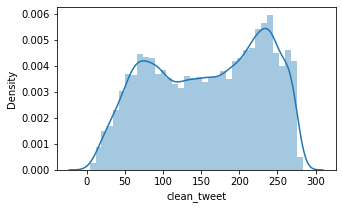

In [34]:
# Plot tweet length distribution
plt.figure(figsize=(5,3))
sns.distplot(df.clean_tweet.str.len())

In [35]:
# Look at shortest tweets. These are mainly aimed directly at people (replies?) or reference other images or tweets.
# They contain nouns (hence passed the exclusion) but don't seem to have a pattern I can easily discern around noun type or determiner. 

df[df['clean_tweet'].str.len() < 42].head()

,clean_tweet,emojis,hashtags_clean,mentions,likes,link_check,time,verified,user,tweets,spacy,prep_tweet_stops,prep_tweet,noun_check,polarity,subjectivity
21,President at COP26,[],[COP26],"[GreenCongressKE, Martin_Ogindo]",1,True,2021-11-04 10:10:29,False,Harold Mugozi,@GreenCongressKE President @Martin_Ogindo at ...,"(President, at, COP26)","[president, at, cop26]",[president],True,0.0,0.0
179,Its Energy Day at COP26,[],[COP26],[],0,True,2021-11-04 10:06:59,False,Burnham & Weston Energy CIC,It's Energy Day at #COP26. https://t.co/CHLINu...,"(Its, Energy, Day, at, COP26)","[its, energy, day, at, cop26]","[energy, day]",True,0.0,0.0
224,We have liftoff GlasgowDeclaration COP26,[],"[GlasgowDeclaration, COP26]","[1PlanetTourism, UNWTO, VisitScotland, Tourism...",27,True,2021-11-04 10:05:35,False,Travel Foundation,We have lift-off! #GlasgowDeclaration #COP26 @...,"(We, have, liftoff, GlasgowDeclaration, COP26)","[we, have, liftoff, glasgowdeclaration, cop26]","[liftoff, glasgowdeclaration]",True,0.0,0.0
229,COP26 Do as I say not as I do,[],[COP26],[],2,False,2021-11-04 10:05:28,False,chris collings 💚⚓️💙🏴󠁧󠁢󠁷󠁬󠁳󠁿🇬🇧,"#COP26 Do as I say, not as I do.","(COP26, Do, as, I, say, not, as, I, do)","[cop26, do, as, say, not, as, do]",[],True,0.0,0.0
232,And back at the COP26,[],[COP26],[],1,True,2021-11-04 10:05:23,False,Oceane,And back at the #COP26 https://t.co/Zwfpw9eGeK,"(And, back, at, the, COP26)","[and, back, at, the, cop26]",[],True,0.0,0.0


In [36]:
# Remove tweets that are too short and unrepresentative of our overall data from our graph
df = df[df['clean_tweet'].str.len() > 42]

In [37]:
df.reset_index(drop = True, inplace = True )

## 1. Topic Modelling - DOC2VEC + Clustering

Doc2vec is built heavily on word2vec produced by Google. Doc2vec works in a similar format, but instead of trying to produce a vector representation of each word, it also produces a vector representation of the whole document. The aim of the model is that vector representation of similar documents will be closer together than vector representations of different documents.
* Applied via Gensim, see documentation: https://radimrehurek.com/gensim/models/doc2vec.html
* Good overview of word2vec: https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa - note that the main difference is in an introduction to of a document tag when using doc2vec.

Once we have the vector representations we can run clustering on our vectors to find topics that should relate to each other. I have used K-Means clustering as it is less computationally expensive then Fuzzy C-Means clustering (but that latter may have better performance on a heavily overlapping dataset such as ours).



In [38]:
# Using the preprocessed text in our prep_tweet column, tag the documents using Gensims TaggedDocument function
tagged_data = [TaggedDocument(words = prepped_tweet, tags=[str(iterable_i)]) for iterable_i, prepped_tweet in enumerate(df.loc[:, 'prep_tweet'])]
tagged_data_stops = [TaggedDocument(words = prepped_tweet, tags=[str(iterable_i)]) for iterable_i, prepped_tweet in enumerate(df.loc[:, 'prep_tweet_stops'])]

In [39]:
# Train a dcoc2vec model on our dataset of prepared tweets.
d2v_model = Doc2Vec(vector_size = 100, epochs = 40, min_count = 2, seed = 73 )
d2v_model.build_vocab(tagged_data)
d2v_model.train(tagged_data, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

In [40]:
# Produce doc2vec vectors for all documents to perform K-means clustering upon
vectors = []
for doc_id in range(len(tagged_data)):
    inferred_vector = d2v_model.infer_vector(tagged_data[doc_id].words)
    vectors.append(inferred_vector)

In [41]:
# Add the doc2vec vectors for each tweet to our dataset for use later on
df['doc2vec'] = vectors

The below chunks of code can be used to assess the success of the doc2vec model, however to produce

In [42]:
# Print the most similar N documents to the the inputted doc2vec document vector (including the input vector itself which should be vector 0)
def most_similar_sentence(doc_vec, output_num):
    sims = d2v_model.docvecs.most_similar([doc_vec], topn = len(tagged_data) - 1)
    print('This output should match the original text: \n{}'.format(df.loc[int(sims[0][0]), 'clean_tweet']))
    print('*'*20)
    for similar_vec in range(1, output_num):
        print('Vector match {}: {}'.format(str(similar_vec), df.loc[int(sims[similar_vec][0]), 'clean_tweet']))
        print('*'*20)

In [43]:
# Can be run to return a test document, what should be the original document and the N-1 closest matches to our randomly selected test document
random_int = random.randint(0, df.shape[0] - 1)
print('Here is the test document: \n{}'.format(df.loc[random_int, 'clean_tweet']))
print('*'*20)
most_similar_sentence(df.loc[random_int, 'doc2vec'], 5)

Here is the test document: 
Morrisons supermarkets replaced their 10p plastic bags with 25p reusable paper bags Better for the planet Because of Brexit Covid supply issues my local havent had any of these for about 9 months so instead they give you a complimentary plastic bag COP26
********************
This output should match the original text: 
Morrisons supermarkets replaced their 10p plastic bags with 25p reusable paper bags Better for the planet Because of Brexit Covid supply issues my local havent had any of these for about 9 months so instead they give you a complimentary plastic bag COP26
********************
Vector match 1: Sad with COP26 on that youd choose this time to promote the least sustainable food on the planet Michael And local grass fed organic blah blah blahnone of that matters Its selfish madness to continue to promote beef when the planet is burning
********************
Vector match 2: COP26 Climate Over Politics  It became Currency Over Planet 
******************

From running a these random checks many times, the similar vectors generally perform okay, i.e. they are in someway related (by more than just climate change), however I would question whether they really are the most similar tweets in meaning. This is evident when discussing more concrete things such as net zero or fossil fuels.

Begin using K - Means to create our topics:

In [44]:
# # Initialise K-means model for clustering (Assigning takes c.60 mins with 10 repeats)
# kclusterer = KMeansClusterer(11, distance = nltk.cluster.util.cosine_distance, repeats=10)
# assigned_clusters = kclusterer.cluster(vectors, assign_clusters=True)

In [45]:
# #Save kclusterer model
# with open(r'models/v3.model', 'wb') as f:
#  pickle.dump(kclusterer, f)
#  f.close()

# #Save assigned_clusters
# with open(r'models/v3_list', 'wb') as f:
#  pickle.dump(assigned_clusters, f)
#  f.close()

In [46]:
# Load model outputs
kclusterer = pickle.load(open(r'models/v3.model', 'rb'))
assigned_clusters = pickle.load(open(r'models/v3_list', 'rb'))

In [47]:
# Add our assignments to our dataset
df['cluster_kmeans'] = assigned_clusters

In [48]:
# See how large each of our clusters is in this topic model
df.cluster_kmeans.value_counts()

6     10970
8      3609
3      2759
5      2693
9      2477
11     2298
10     2223
4      2076
7      1984
2      1875
0      1489
1      1343
Name: cluster_kmeans, dtype: int64

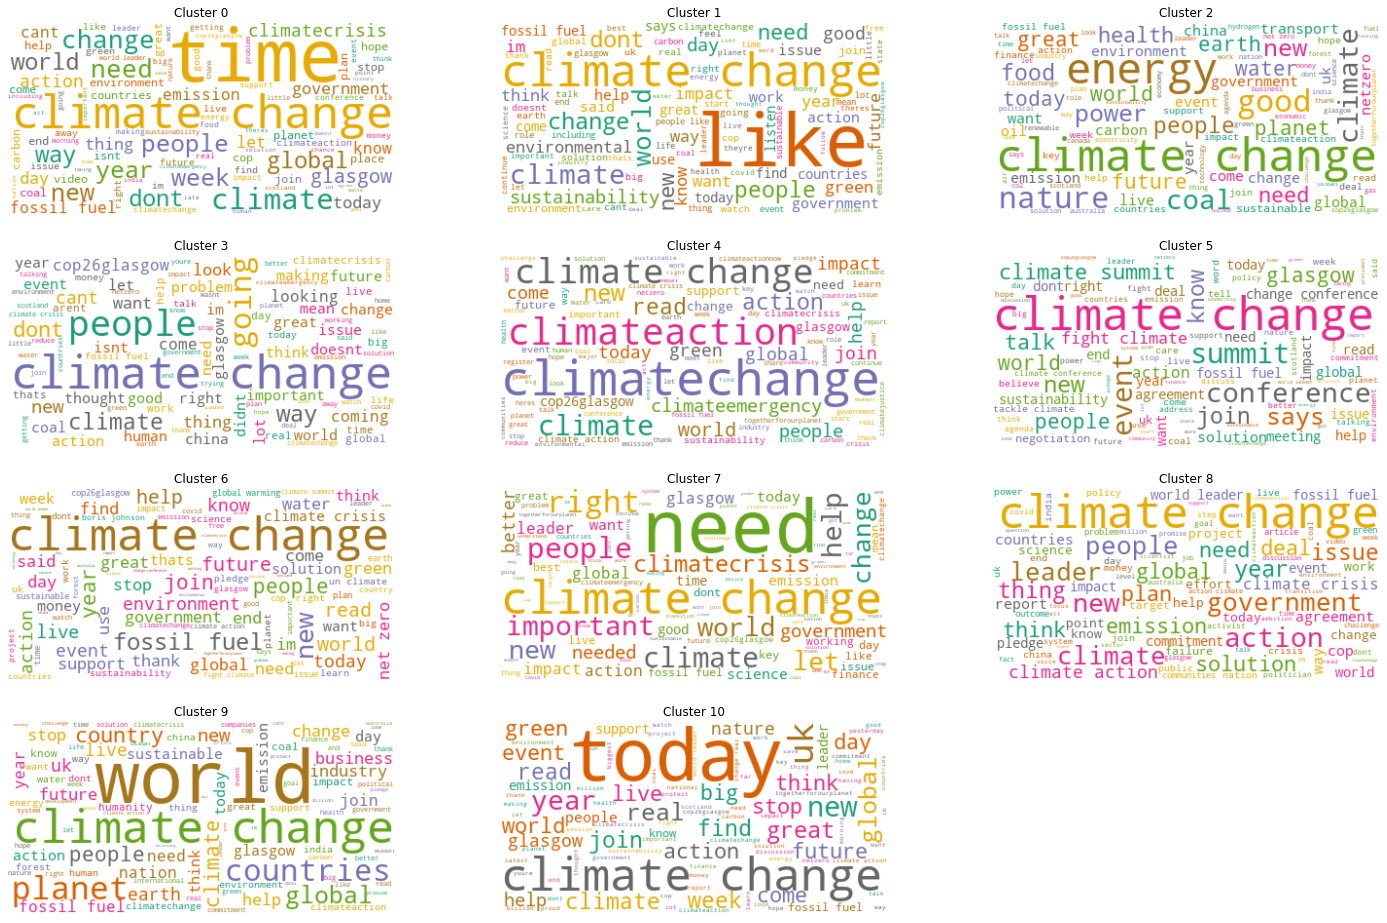

In [49]:
# Print wordclouds of the clusters, to give us a good idea of the topics and themes within that specific topic.
clusters = range(0,11)

plt.figure(figsize = (25,25))

wc = WordCloud(stopwords = nlp.Defaults.stop_words, background_color="white", colormap="Dark2", max_words = 100,
               max_font_size=75, collocations = True, random_state=42)

# Create subplots for each cluster
count = 0
for cluster in clusters:
    wc.generate(' '.join(df[df['cluster_kmeans'] == cluster].clean_tweet.str.lower()))
    plt.subplot(6, 3, count + 1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title('Cluster ' + str(cluster))
    count +=1
    
plt.show()

As we can see in our wordclouds, the topics don't seem that distinct from one another. In fact, it looks like certain words are contributing a lot to our vectors, and are key to each node such as: like, need, today & world.

This is even more suprising given that outside of our main cluster (cluster 6 - containing 30% of the tweets), our clusters are still heavily overlapped.

## 1. Topic Modelling - GDSMM
GDSMM is topic model which only assumes one topic per document (which is much more likely for short from documents such as Tweets compared to the multi topic assumption required for LDA), and has been developed for use in shortform documents such as social media posts.
* GitHub Repo: https://github.com/rwalk/gsdmm
* Full paper here: https://dbgroup.cs.tsinghua.edu.cn/wangjy/papers/KDD14-GSDMM.pdf

In [50]:
# Define the vocab set for our tweets
vocab = set(word for sentence in df.prep_tweet for word in sentence)
n_terms = len(vocab)

In [51]:
# # Fit GSDMM model
# mgp = MovieGroupProcess(K = 30, alpha = 0.09, beta = 0.11, n_iters = 40)
# y = mgp.fit(df.prep_tweet, n_terms)

In [52]:
# # Save GSDMM model
# with open(r'models/v2.model', 'wb') as f:
#  pickle.dump(mgp, f)
#  f.close()

In [53]:
# Load saved model
mgp = pickle.load(open(r'models/v2.model', 'rb'))

In [54]:
# Function to show the most used words in each of our categories 
def top_words(mgp, top_clusters, num_words):
    for cluster in top_clusters:
        sort_dicts = sorted(mgp.cluster_word_distribution[cluster].items(), key = lambda k: k[1], reverse = True)[:num_words]
        print ('-'*30)
        print('Cluster {}: {}'.format(cluster, sort_dicts))

In [55]:
# Output the clusters information in a readable format
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic: {}'.format(np.sort(doc_count)[::-1]))
print('Number of documents per topic :', np.sort(doc_count)[::-1])
print('*'*20)
# Topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-15:][::-1]
print('Most important clusters (by number of docs inside):', top_index)
print('*'*20)
# Show the top 10 words in term frequency for each cluster 
top_words(mgp, top_index, 10)

Number of documents per topic: [8334 5511 4127 3649 2880 2703 2456 2159 1989 1211  269   71   64   51
   46   35   33   30   29   22   21   20   17   17   16   13   10   10
    3    2]
Number of documents per topic : [8334 5511 4127 3649 2880 2703 2456 2159 1989 1211  269   71   64   51
   46   35   33   30   29   22   21   20   17   17   16   13   10   10
    3    2]
********************
Most important clusters (by number of docs inside): [ 9 28 18 22 23  5 24  6 14 15 26  1 10 13  3]
********************
------------------------------
Cluster 9: [('not', 2158), ('people', 1181), ('climate', 940), ('like', 775), ('think', 695), ('world', 693), ('need', 687), ('change', 681), ('know', 562), ('go', 546)]
------------------------------
Cluster 28: [('climate', 1752), ('country', 1036), ('coal', 892), ('fossil', 758), ('fuel', 718), ('glasgow', 643), ('agreement', 608), ('deal', 599), ('world', 598), ('draft', 585)]
------------------------------
Cluster 18: [('climate', 1166), ('need', 5

We can see extreme cut off after 10 clusters, lets look at them in more detail.

In [56]:
# Define major clusters, so that any other clusters are joined together
clusters = top_index[0:10]

In [57]:
# Assign the model classifcations to our data
def label_cluster(doc_tokens):
    cluster = mgp.choose_best_label(doc_tokens)[0]
    if cluster not in clusters:
        cluster = 99
    return cluster

def label_prob(doc_tokens):
    probability = mgp.choose_best_label(doc_tokens)[1]
    return probability

df['cluster'] = df.prep_tweet.apply(lambda x: label_cluster(x))
df['probability'] = df.prep_tweet.apply(lambda x: label_prob(x))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.6, 1.0)

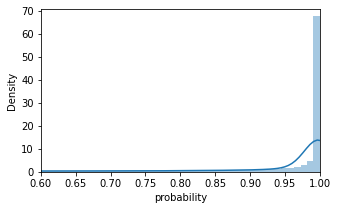

In [58]:
# Plot cluster probabilities 
plt.figure(figsize=(5,3))
sns.distplot(df.probability, bins = 100)
plt.xlim(0.6,1)

The probabilities output by the model are very high (a very small number of entries are left off the graph to the left)

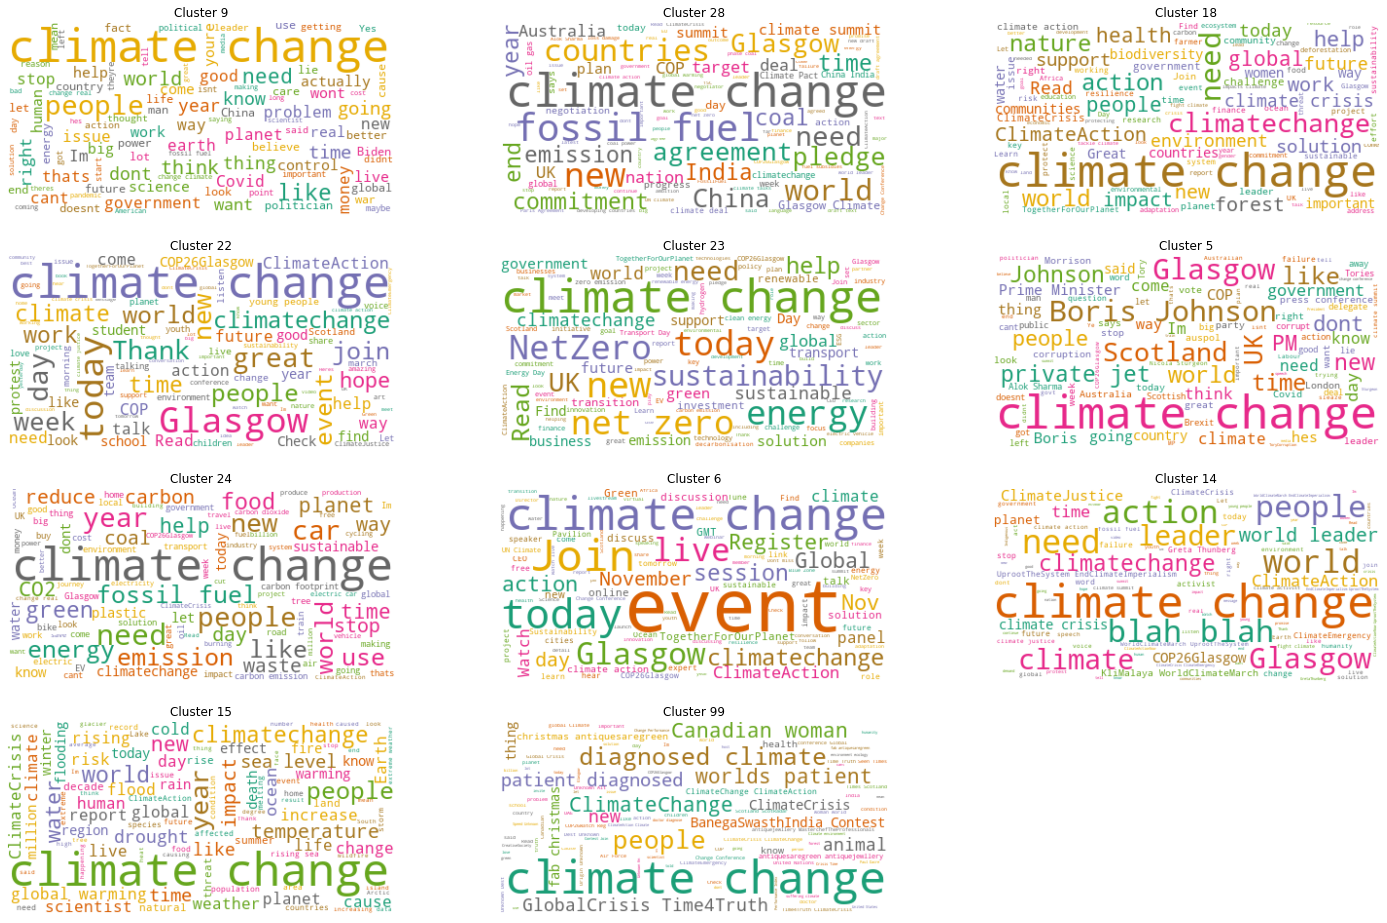

In [59]:
clusters = np.append(clusters, 99)

plt.figure(figsize = (25,25))

wc = WordCloud(stopwords = nlp.Defaults.stop_words, background_color="white", colormap="Dark2", max_words = 100,
               max_font_size=75, collocations = True, random_state=42)

# Create subplots for each cluster
count = 0
for cluster in clusters:
    wc.generate(' '.join(df[df['cluster'] == cluster].clean_tweet))
    plt.subplot(6, 3, count + 1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title('Cluster ' + str(cluster))
    count +=1
    
plt.show()

Looking at these clusters we can some clear topics have been found within our dataset (99 is an amalgamation of the other categories) - this is my interpretation of each topic so far:
- 9 - General climate change vocabulary
- 28 - Fossil fuels and emissions agreements
- 18 - Call to action for health / nature / planet
- 22 - Event specific (days, timings, glasgow)
- 23 - Net zero 
- 5 - Politics around the event (Glasgow, Boris, private jets etc)
- 24 - Waste / Emissions and calls for alternatives
- 6 - Event specific (days, timings, glasgow
- 14 - Hashtags from COP
- 15 - Effect of Climate Change on Earth (Drought, carbon water etc)
- 99 - No clear topic - need to investigate the diagnosed bigrams

Due to notebooks, it is hard to convey the above information consistently throughout this document, I therefore recommend copying this to notepad so you can see the topic content when looking at topic sentiment below.


## 2. Overall Sentiment

Sentiment here is being measuered by textblob (via spacy), which is a simple implementation that has every word assigned a polarity and subjectivity to its various meanings. The score of each meaning is averaged for the word and then summed up across the text.

It does allow for adverbs such as 'very' and for negatives such as 'not'.

Text(0, 0.5, '<-- Facts -------- Opinions -->')

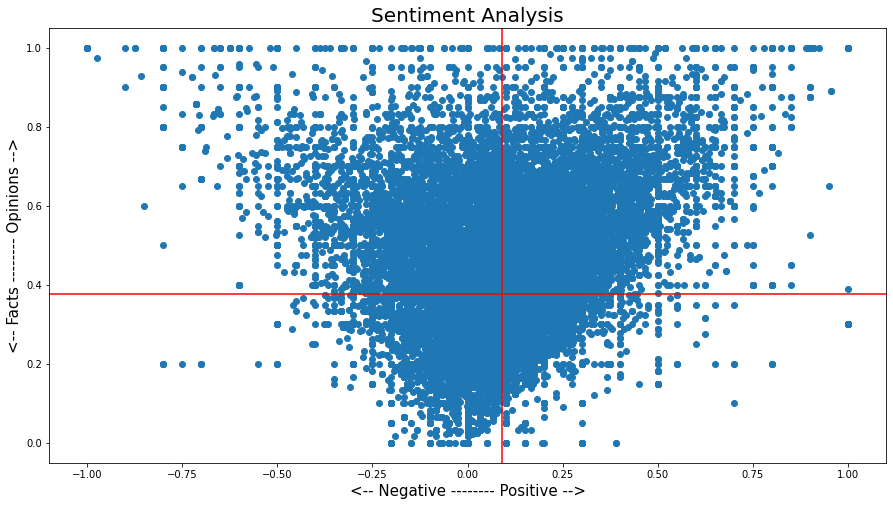

In [60]:
# Plot the sentiment scores of all of our tweets.
# Can clearly see a triangular shape, which showing that the more factual a tweet is, the more likely it is to be neutral
plt.figure(figsize = (15,8))
plt.scatter(df['polarity'], df['subjectivity'])
plt.axhline(y = df['subjectivity'].mean(), color='r', linestyle='-')
plt.axvline(x = df['polarity'].mean(), color='r', linestyle='-')
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

In [61]:
print('Here we can see that our average polarity is: {} \nand our average subjectivity is: {}'.format(round(df['polarity'].mean(),4), round(df['subjectivity'].mean(),3)))

Here we can see that our average polarity is: 0.0903 
and our average subjectivity is: 0.378


As expected, we can see a common trend where the more factual someone is, the more neutral they are. I have added the average polarity (neg to pos) and subjectivity (fact to opinion) as the scatter graph doesn't adeqately convey density without it.



I haven't been able to find many benchmarks for sentiment of a wide variety of tweets (which is understandable given the amount of data available on twitter). Given that we are particularly looking at climate change, even if we found a benchmark, it may not be relevant to our dataset. We could really only compare this to a feed over time (say every 6-12 months) which would require us to have a licensed API.

# 3. Topic / Theme Sentiment

Given that the GDSMM model outputted more coherent topics than the doc2vec method, I have used those topics to perform our sentiment analysis on,


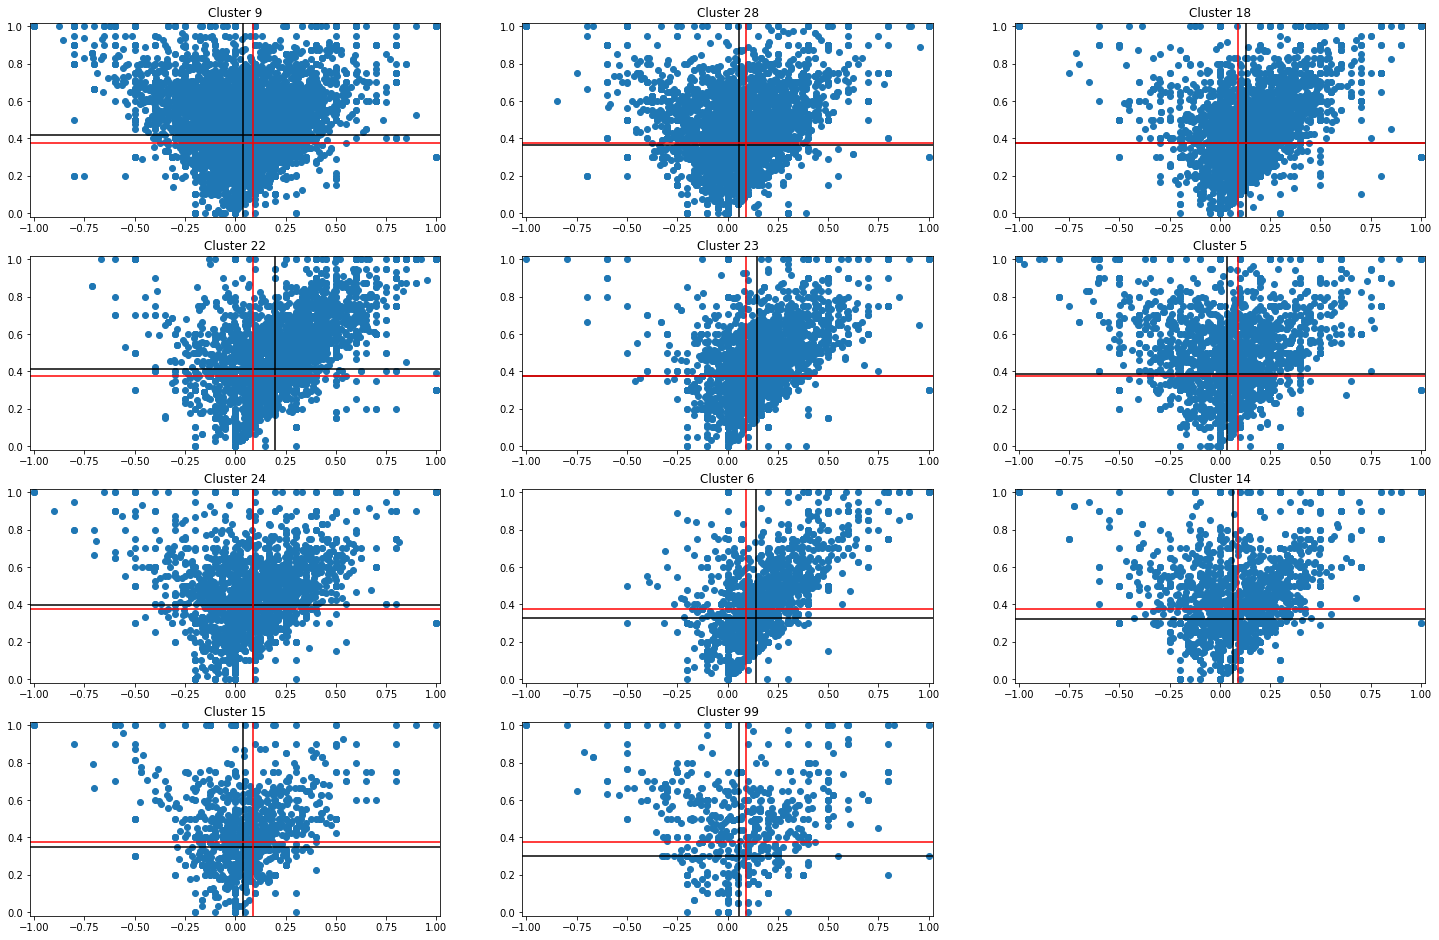

In [62]:
plt.figure(figsize = (25,25))
# Create subplots for each cluster - Red is the original sentiment on the dataset and black is the sentiment for that specific cluster
count = 0
for cluster in clusters:
    temp_df = df[df['cluster'] == cluster]
    plt.subplot(6, 3, count + 1)
    plt.scatter(temp_df['polarity'], temp_df['subjectivity'])
    plt.title('Cluster ' + str(cluster))
    plt.ylim(-0.02,1.02)
    plt.xlim(-1.02,1.02)
    plt.axhline(y = temp_df['subjectivity'].mean(), color='k', linestyle='-')
    plt.axvline(x = temp_df['polarity'].mean(), color='k', linestyle='-')
    plt.axhline(y = df['subjectivity'].mean(), color='r', linestyle='-')
    plt.axvline(x = df['polarity'].mean(), color='r', linestyle='-')
    count += 1
plt.show()

We can see in these graphs the sentiment for each individual cluster. The red axis show the average sentiment over the entire dataset while the black axis show the sentiment for the specific cluster displayed. There seems to be more variance in sentiment than in subjectivity for the clusters.

Interesting call outs are: 
- For all clusters with a positively shifted polarity, we lose the classic V shape we had in our original graph, and we see mainly the positive half of our graph (/). However we don't see the reverse for the charts with a negatively shifted polarity.
- The larges positive shifts were seen in the event specific tweet clusters, along with call the action clusters about planetary health and net zero (note these are more focused in the future).
- Negative polatiry shifts were seen for the fossil fuel and effects of climate change clusters (along with the political cluster).


I also ran the sentiment through another sentiment model called Vader, which is designed for social media. I also added in the description of emojis, as they can also add sentiment to a tweet however the polarity distribution was very similar overall to text blob, so I've commented out the code for ease of running.

* Example usage of Vader: https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664
* GitHub link: https://github.com/cjhutto/vaderSentiment

Note it is also available via NLTK

In [63]:
# Add emoji descriptions back into the clean tweets for sentiment analysis
df['temp_emojis'] = [' '.join(map(str, item)) for item in df['emojis']]
df['temp_clean_tweet'] = df['clean_tweet'] + ' ' + df['temp_emojis']

In [64]:
# Run a second sentiment analysis using vader, which has been designed for use on social media data
# GitHub here: https://github.com/cjhutto/vaderSentiment
df['vs_polarity'] = df.temp_clean_tweet.apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['compound'])
df = df.drop(columns = ['temp_emojis', 'temp_clean_tweet'])

In [65]:
# # Check min and max of polarity
# print(df.vs_polarity.max())
# print(df.vs_polarity.min())

In [66]:
# # Overall plot os polarity
# sns.histplot(data = df, x = 'vs_polarity')

In [67]:
# # Create the hist plots for sentiment over each cluster
# fig, axes = plt.subplots(6,2, figsize=(20,25))
# fig.tight_layout(pad = 4)
# count = 0
# for name, ax in zip(clusters, axes.flatten()):
#     temp_df = df[df['cluster'] == name]
#     ax.set_title('Cluster ' + str(name))
#     sns.histplot(data = temp_df, x = 'vs_polarity', ax=ax)
#     count += 1

In [68]:
# # Polarity differences between the two polarity methods
# df['pol_diff'] = df['vs_polarity'] - df['polarity']

# # Look at tweet lengths - note these include the stop words, so length is overstated for modelling purposes
# print('The largest negative shift is:', df['pol_diff'].min())
# print('The 5% percentile:', df['pol_diff'].quantile(q=0.05))
# print('The mean shift:', df['pol_diff'].quantile(q=0.5))
# print('The 95th percentile:', df['pol_diff'].quantile(q=0.95))
# print('The largets postive shift is:', df['pol_diff'].max())

# # Plot tweet length distribution
# plt.figure(figsize=(8,5))
# sns.distplot(df.pol_diff)


## 4. Climate Change Scepticism - Doc2vec

In [69]:
# Manually reviewed raw data to pull some users who posted about climate sceptacism
users_of_interest = ['Liarpoliticians, UK has a rogue Parliament+police',
 'Orama Spilsbury',
 'Full Metal Husky',
 'Craig Murray',
 'Sal Michael',
 'Sandi Kear',
 'Valentin Havugiyaremye']

In [70]:
# Pull tweets posted by above users
manual_scep_df = df.loc[df['user'].isin(users_of_interest)]
print('Identified {} tweets'.format(manual_scep_df.shape[0]))
manual_scep_df.index

Identified 10 tweets


Int64Index([235, 356, 757, 9818, 10627, 11336, 11454, 11804, 12405, 12846], dtype='int64')

In [71]:
# Visualise the above
manual_scep_df.head().clean_tweet.values

array(['COP  CONTROL OF PEOPLE The terrorist 01 are losing the narrative on the covid19 PLANdemic so now pushing their WEF religion of ClimateChange for GreatReset BuildBackBetter Crimes Against Humanity CrimesAgainstHumanity genocide cop26',
       'Today the state propaganda machines are telling us that Carbon emissions are on the rise after the PLANdemic lockdowns but didnt the UN just tell us two weeks ago that it never fell during the lockdowns Make up your minds on fake ClimateChange cop26',
       'Nobody believes America England or Australias lofty climate change announcements basking in fake sincerity Americas Air Force USAF alone emits more than 41 countrys carbon China urges US climate action not empty rhetoric COP26 via',
       'Last week I joined world leaders at the UN Climate Scam Summit to talk about screwing New Mexico with the climate change hoax Were stealing your money for fake renewable energy to kill real jobs and destroy our economy while creating an unsustainab

In [72]:
# Repurpose the doc2vec sense check to run on the manually selected entries
# [235, 356, 757, 9818, 10627, 11336, 11454, 11804, 12405, 12846]
random_int = 356
print('Here is the test document: \n{}'.format(df.loc[random_int, 'clean_tweet']))
print('*'*20)
most_similar_sentence(df.loc[random_int, 'doc2vec'], 5)

Here is the test document: 
Today the state propaganda machines are telling us that Carbon emissions are on the rise after the PLANdemic lockdowns but didnt the UN just tell us two weeks ago that it never fell during the lockdowns Make up your minds on fake ClimateChange cop26
********************
This output should match the original text: 
Today the state propaganda machines are telling us that Carbon emissions are on the rise after the PLANdemic lockdowns but didnt the UN just tell us two weeks ago that it never fell during the lockdowns Make up your minds on fake ClimateChange cop26
********************
Vector match 1: Yeah well I cant state anything bc I felt climate change very well in my country xD When I was younger 25C was an insane wow but now meh its gonna be 33C whole week Is fiiiine Is usual now
********************
Vector match 2: The most harmful lie being spread about climate change today is not that it is fake Its that nothing you can do can help save the world Atkin
*

Running the test on some of the entries selected gives very reasonable similar messages that also have climate change scepticism.

In [73]:
# Define a function to find the index of similar tweets given a doc2vec entry vector
def most_similar(doc_vec, output_num):
    sims = d2v_model.docvecs.most_similar([doc_vec], topn = output_num)
    out_list = []
    for similar_vec in range(0, output_num):
        out_list.append(sims[similar_vec][0])
    return out_list

In [74]:
# Pull 4 tweets similar to EACH of the original climate change sceptic tweets manually identified
# Then add them into a list so that a new df can be created using the new indexes
post_man_index_temp = []
for doc_index in manual_scep_df.index:
    post_man_index_temp.append(most_similar(doc_vec = manual_scep_df.loc[doc_index, 'doc2vec'], output_num = 5))

post_man_index = [int(doc_index) for similar_docs in post_man_index_temp for doc_index in similar_docs]
index_counter = Counter(post_man_index)
post_man_index = list(set(post_man_index))
post_man_index.sort()

scep_df = df.loc[post_man_index,:]

print('We have identified {} new tweets using this process'.format(scep_df.shape[0] - 10))

We have identified 39 new tweets using this process


In [75]:
# See how many of the recommendations overlap - a high amount over lap would imply the process works well
# But low amount of overlap doesn't imply that it doesn't (could be a broad topic of sentiment)
index_counter.most_common(5)

[(14135, 2), (235, 1), (29489, 1), (35041, 1), (2510, 1)]

In [76]:
# Print the tweets found using doc2vec similarity (excluding the originals)
scep_df[~scep_df.index.isin(manual_scep_df.index)].tweets.values

array(['How can we ensure that the cost of transitioning to net zero is distributed fairly? #COP26 \n\nWe explain in this thread 👇 https://t.co/HQ3eJUIfvu',
       'More than 40 countries agree to phase out coal-fired power- #cop #cop26 #climatechange #climateaction https://t.co/LN8xIUnzXA',
       '@MichaelEMann There’s so much legitimate criticism, what are you considering “pissing on” #COP26',
       'In the words of a great friend…is cop26 just a massive piss up at tax payers expenses #COP26',
       "NZ... 60% of our energy still comes from fossil fuels. In fact, we use around 46 million barrels of crude oil every year - that's more than 1,600 litres of crude oil per person, per year. #COP26",
       "@ScotNational Scottish independence could enhance Scotland's climate action by ending the UK’s war on electricity exports from Scotland and lifting barriers to renewable energy trading with England and Wales and beyond.\nhttps://t.co/tj7KGGgRMJ\n\n#AUOB #COP26",
       "Thunberg: #CO

When we pulled 9 tweets for each original found, a fair proportion of them didn't seem to show the same sceptiscm the originals did.

When reducing it down to 4, we see a high proportion of similar sentiment, but it is far from perfect.

## 4. Climate Change Scepticism - Spacy Similarity Scoring



In [77]:
# Pull some indexes for testing similarity score
sim_indexes = most_similar(df.loc[235, 'doc2vec'], 15)
sim_index_test = sim_indexes[1:]
sim_index_orig = sim_indexes[0]

In [78]:
# Test if doc2vec and spacy agree for what the most similar document is#
# From outputs we can see that they don't
for index_iter in sim_index_test:
    similarity = df.loc[int(sim_index_orig), 'spacy'].similarity(df.loc[int(index_iter), 'spacy'])
    print('Similarity between {} and {} is: {}'.format(sim_index_orig, index_iter, similarity))

Similarity between 235 and 29489 is: 0.7986495143204982
Similarity between 235 and 35041 is: 0.804907018901131
Similarity between 235 and 2510 is: 0.8228577200413963
Similarity between 235 and 10082 is: 0.880514664157029
Similarity between 235 and 8367 is: 0.8799427176258454
Similarity between 235 and 8842 is: 0.8198312093814187
Similarity between 235 and 30676 is: 0.8120998174724487
Similarity between 235 and 17293 is: 0.6812018877574583
Similarity between 235 and 33197 is: 0.7787788374099213
Similarity between 235 and 4060 is: 0.8146359542916057
Similarity between 235 and 31699 is: 0.8009292283662123
Similarity between 235 and 11105 is: 0.8252474479694976
Similarity between 235 and 22213 is: 0.8104664450693138
Similarity between 235 and 21815 is: 0.817611796002701


In [79]:
num_temp = 19435   
print(df.loc[num_temp, 'polarity'])
print(df.loc[num_temp, 'tweets'])

-0.15000000000000002
Do they call it #COP because the lack of action is criminal? #COP26


In [80]:
# Define function to return the most similar documents via spacy
def most_similar_spacy(input_index, output_num):   
    index_list = list(df.index)
    index_list.remove(input_index)
    run_index = []
    run_sim = []
    for index_iter in index_list:
        similarity = df.loc[int(input_index), 'spacy'].similarity(df.loc[int(index_iter), 'spacy'])
        run_index.append(index_iter)
        run_sim.append(similarity)
    
    np_index = np.array(run_index)
    np_sim = np.array(run_sim)
    out_np_index = np.sort(np_sim)[-output_num:][::-1]
    out_np_sim = np_sim.argsort()[-output_num:][::-1]

    return out_np_index, out_np_sim

In [93]:
# Pull 4 tweets similar to EACH of the original climate change sceptic tweets manually identified
# Then add them into a list so that a new df can be created using the new indexes
spacy_sim_temp = []
spacy_index = []
for doc_index in manual_scep_df.index:
    spacy_sim_temp.append(most_similar_spacy(doc_index, output_num = 10)[1]) # Weirdly need to reference the outputs in the wrong order to pull back the correct figures (try and fix tomorrow)

spacy_sim = [doc_index for similar_docs in spacy_sim_temp for doc_index in similar_docs]

similar_counter = Counter(spacy_sim)
spacy_sim = list(set(spacy_sim))
spacy_sim.sort()

scep_df = df.loc[spacy_sim,:]

print('We have identified {} new tweets using this process'.format(scep_df.shape[0] - 10))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  


We have identified 86 new tweets using this process


In [95]:
scep_df.tweets.values

array(['@boucherhayes @taraconnollyGW Pledges .... \n\nThese pledges must = action on the ground!\n\nAction = global political, social &amp; economic change &amp; disruption...\n\nWe have a way to go yet... #COP26',
       '@ProfMarkMaslin @wrightonthenail @Kevin_Fong @mattwinning @dwallacewells @whippletom @daisydunnesci @DeborahMeaden @FinnHarries @CFigueres @jrockstrom Veridian at County Farm in Ann Arbor\n⚡💯 Electric 💡\n🛢️NO gas\n🔆1.3MW solar net zero\n🔋 battery storage\n🛒9 food markets within 3-5 minutes walk/bike\n👩\u200d🌾 Onsite food production\n🅾️zero waste goals\n\nBreaking ground soon. Proof positive!\n\n#COP26 \n#netzero NOW',
       '#GlobalWarming #ClimateChange #ClimateCrisis \nRt\nLakes in Northern Hemisphere Warming Alarmingly Fast https://t.co/4ZH6kojbL3',
       'COP26 | Artists On Climate Change | Jenny Holzer et. al.\nhttps://t.co/GsIW29sL3E',
       '@MattWalshBlog Because those adults are insidious,sordid, sneaky humans!Always have an agenda, exploiting people’s f

## 5. Named Entity Recognition
Let us look to bring out the key entities mentioned in all our texts

In [ ]:
ent_type_dict = {}

In [ ]:
# Create a function to extract our named entities, excluding Cardinals (numerals that are uncategorized) 
# Writes entities to ent_type_dict if not already included which maps to spacy ent.label_ (descriptions available via spacy.explain(ent.label_))
def extract_ents(doc):
    doc_list = []
    if doc.ents:
        for ent in doc.ents:
            if ent.label != 397: # Exclude cardinals
                doc_list.append(ent.text)
                if ent.label_ not in ent_type_dict.keys(): # Write to ent_type_dict if entry does not yet exist
                    ent_type_dict[ent.text] = ent.label_
    return(doc_list)

In [ ]:
df['entities'] = df.spacy.apply(lambda x: extract_ents(x))

In [ ]:
# Create some variables describing the entities found in our tweets
entity_list = df.entities.to_list()
all_entities = [entities for entities_sub_list in entity_list for entities in entities_sub_list] # List of all entities (with repetition)
unique_entities = list(set(all_entities)) # List of all entities (without repitition)
entity_counts = dict(zip(unique_entities, [all_entities.count(entities) for entities in unique_entities])) # Dictionary of entity counts
entity_counter = Counter(entity_counts)
common_entities = entity_counter.most_common(20)
for i in common_entities:
    print(i[0], ':', i[1])

In [ ]:
# For some common entities, print the Entity type identifed by Spacy
print('COP =',ent_type_dict['COP'])
print('ClimateAction =',ent_type_dict['ClimateAction'])
print('ClimateChange =',ent_type_dict['ClimateChange'])
print('Climate Change =',ent_type_dict['Climate Change'])
print('Glasgow =',ent_type_dict['Glasgow'])

In [ ]:
sorted_common_entities = sorted(entity_counter.items(), key = lambda pair: pair[1], reverse = True)

In [ ]:
def common_ent_type(sorted_input_entities, ent_dict, ent_type, num_output = 20):
    ent_of_type = []
    count = 0
    while len(ent_of_type) < num_output:
        if ent_type_dict[sorted_common_entities[count][0]] == ent_type:
            ent_of_type.append(sorted_common_entities[count][0])
            count += 1
        else:
            count +=1
    return ent_of_type


In [ ]:
testing_people = common_ent_type(sorted_common_entities, ent_type_dict, 'PERSON', 30)
testing_people

In [ ]:
testing_orgs = common_ent_type(sorted_common_entities, ent_type_dict, 'ORG', 20)
testing_orgs

In [ ]:
testing_norp = common_ent_type(sorted_common_entities, ent_type_dict, 'NORP', 10)
testing_norp

Here we see that the default NER model within SpaCy is doing a reasonable job at pulling out Names, Organisations and NORPs. However, there are a few incorrect name labels (Glasgow, KliMaya & Brexit) and some common hashtags have been flagged as organisations. These errors are unstandable given the context they are written in (tweets generally don't follow grammar rules as much as other written sources) but could be improved by fine tuning the NER model which would require a training dataset to be made. This may be a lot of work (more examples is always better), especially if we want to expand this out past just climate change.

Fairly good explanation of how to update the NER model can be found here:
- https://www.machinelearningplus.com/nlp/training-custom-ner-model-in-spacy/

In [ ]:
df.loc[211,:]

In [ ]:
df[df.user == 'David']

In [ ]:
false_ls = []
for doc in docs:
    for token in doc:
        if token.has_vector == False:
            false_ls.append(token.text)

token_counter = Counter(false_ls)

In [ ]:
token_counter.most_common(25)

In [ ]:
print(len(false_ls))
false_ls = list(set(false_ls))
print(len(false_ls))